In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Total cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

def new_phenom_rename(df, observable):
    df.rename(columns={'t_lab':'energy'}, inplace=True)
    df.rename(columns={'observable':'experimental_value'}, inplace=True)
    df.rename(columns={'error':'sigma'}, inplace=True)
    df['observable']=observable
    
def combine_data_new():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #new phenomenological data
    sgt_small= pd.read_csv('CSV_files/sgt_0_75.csv')
    sgtt_small=pd.read_csv('CSV_files/sgtt_0_75.csv')
    sgt_large=pd.read_csv('CSV_files/sgt_75_350.csv')
    sgtt_large=pd.read_csv('CSV_files/sgtt_75_350.csv')
    new_phenom_rename(sgt_small,'   SGT ')
    new_phenom_rename(sgtt_small,'   SGTT')
    new_phenom_rename(sgt_large,'   SGT ')
    new_phenom_rename(sgtt_large,'   SGTT')
    new_data = pd.concat([sgt_small, sgt_large, sgtt_small, sgtt_large])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data, new_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def combine_data_old():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def gauss_factor(combined_data, mu, sigma):
    ###create Gaussian factor 
    #Gaussian distribution
    combined_data['Gauss_factor'] = np.random.normal(mu, sigma, len(combined_data.energy))
    combined_data['Gauss_exp'] = combined_data.apply(lambda row: ((row.K_experimental_value) + (row.K_sigma*row.Gauss_factor)), axis=1)
    #remove unecessary columns
    combined_data = combined_data.drop(columns=['K_experimental_value', 'K_sigma', 'experimental_value', 'k', 'sigma', 'Gauss_factor'])
    return combined_data

In [2]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
#add k*exp columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()

In [3]:
color_options=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

predictions_color      = 'black'
experimental_color     = 'cyan'
phenomenological_color = 'magenta'

pred_alpha         = 1.0
exp_alpha          = 0.8
phenom_alpha       = 0.8
exp_error_alpha    = 0.5
phenom_error_alpha = 1.0

if (predictions_color=='blue'):
    pred_str='bo'
if (predictions_color=='green'):
    pred_str='go'
if (predictions_color=='red'):
    pred_str='ro'
if (predictions_color=='cyan'):
    pred_str='co'
if (predictions_color=='magenta'):
    pred_str='mo'
if (predictions_color=='yellow'):
    pred_str='yo'
if (predictions_color=='black'):
    pred_str='ko'   
if (experimental_color=='blue'):
    exp_str='bo'
if (experimental_color=='green'):
    exp_str='go'
if (experimental_color=='red'):
    exp_str='ro'
if (experimental_color=='cyan'):
    exp_str='co'
if (experimental_color=='magenta'):
    exp_str='mo'
if (experimental_color=='yellow'):
    exp_str='yo'
if (experimental_color=='black'):
    exp_str='ko'   
if (phenomenological_color=='blue'):
    phen_str='bo'
if (phenomenological_color=='green'):
    phen_str='go'
if (phenomenological_color=='red'):
    phen_str='ro'
if (phenomenological_color=='cyan'):
    phen_str='co'
if (phenomenological_color=='magenta'):
    phen_str='mo'
if (phenomenological_color=='yellow'):
    phen_str='yo'
if (phenomenological_color=='black'):
    phen_str='ko'

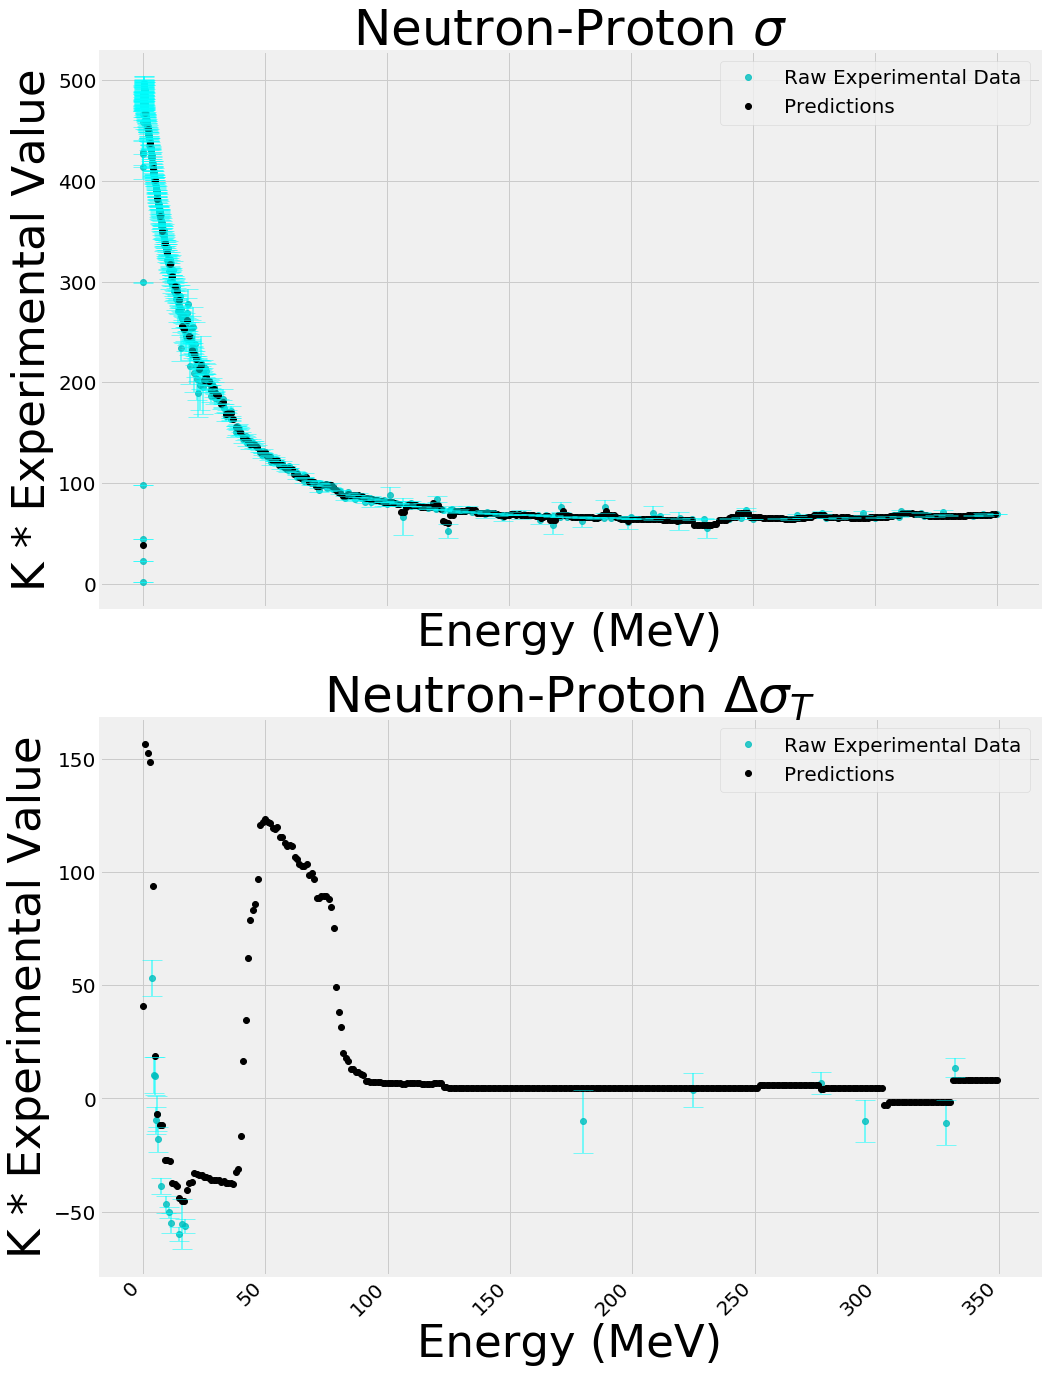

In [4]:
#read data file
data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
data.rename(columns={"statistical_error": "sigma"}, inplace=True)
#add k*exp column
change_np(data)
#remove columns that are not needed
data = data.drop(columns=['scattering_angle', 'K_sigma', 'sigma', 'systematic_error', 'normalization', 'experimental_value', 'reaction_type'])

#One-hot encode
features = pd.get_dummies(data)
# Labels are the values we want to predict
labels = np.array(features['K_experimental_value'])
# Remove the labels from the features
features = features.drop('K_experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size/2), interval_size))
for value in range(0, 350 + int(interval_size/2), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)

#generate arrays for plotting
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,25))
fig.autofmt_xdate(rotation = 45)
#plot 1
ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], exp_str, alpha=exp_alpha, label='Raw Experimental Data')
ax1.plot(E, SGT_predictions, pred_str,  alpha=pred_alpha, label='Predictions')

ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, ecolor=experimental_color, linestyle='none', capsize=10, elinewidth=2, alpha=exp_error_alpha, label='')

ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=45); ax1.set_ylabel('K * Experimental Value', fontsize=45); ax1.set_title('Neutron-Proton $\sigma$', fontsize=50)

#plot 2
ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], exp_str, alpha=exp_alpha, label='Raw Experimental Data')
ax2.plot(E, SGTT_predictions, pred_str, alpha=pred_alpha, label='Predictions')

ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, ecolor=experimental_color, linestyle='none', capsize=10, elinewidth=2, alpha=exp_error_alpha, label='')

ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=45); ax2.set_ylabel('K * Experimental Value', fontsize=45); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=50)

#save figures
plt.savefig('Plots/Presentation_Plots/predictions_no_phenom.pdf', format='pdf', bbox_inches='tight', transparent=True)

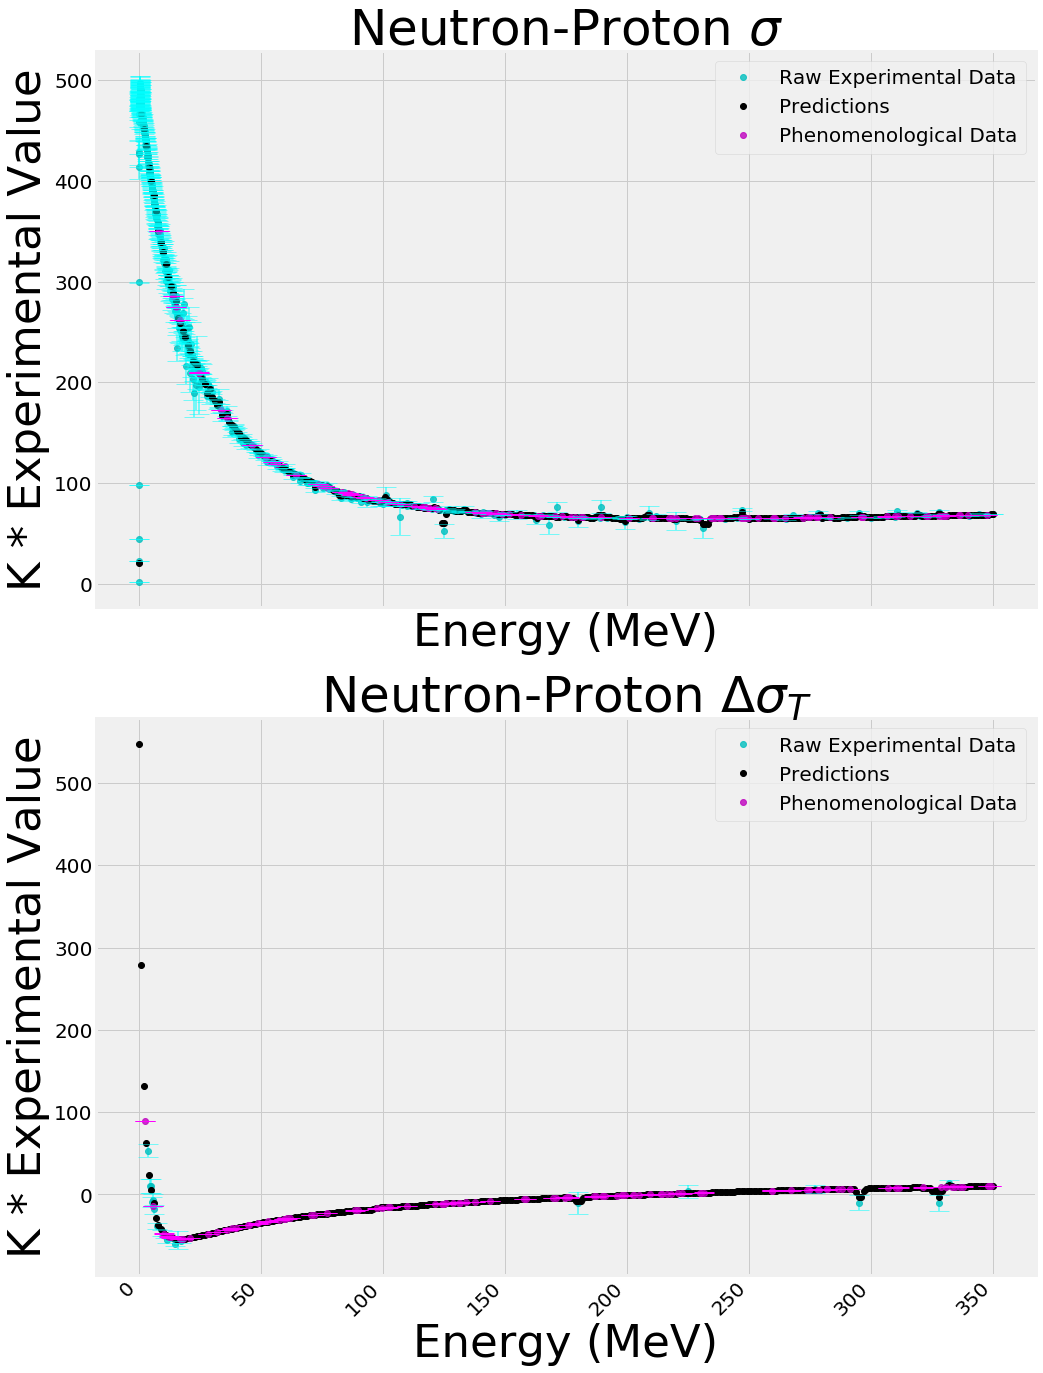

In [5]:
###create combined dataframe
combined_data=combine_data_new()
#combined_data=combine_data_old()
###create Gaussian factor 
combined_data=gauss_factor(combined_data, 0, 0)
#One-hot encode
features = pd.get_dummies(combined_data)
# Labels are the values we want to predict
labels = np.array(features['Gauss_exp'])
# Remove the labels from the features
features = features.drop('Gauss_exp', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size), interval_size))
for value in range(0, 350 + int(interval_size), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,25))
fig.autofmt_xdate(rotation = 45)
#plot 1
ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], exp_str, alpha=exp_alpha, label='Raw Experimental Data')
ax1.plot(E, SGT_predictions, pred_str,  alpha=pred_alpha, label='Predictions')
ax1.plot(random_sgt['energy'], random_sgt['K_experimental_value'], phen_str, alpha=phenom_alpha, label='Phenomenological Data')

ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, ecolor=experimental_color, linestyle='none', capsize=10, elinewidth=2, alpha=exp_error_alpha, label='')
ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, ecolor=phenomenological_color, linestyle='none', capsize=10, elinewidth=2, alpha=phenom_error_alpha, label='')

ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=45); ax1.set_ylabel('K * Experimental Value', fontsize=45); ax1.set_title('Neutron-Proton $\sigma$', fontsize=50)

#plot 2
ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], exp_str, alpha=exp_alpha, label='Raw Experimental Data')
ax2.plot(E, SGTT_predictions, pred_str, alpha=pred_alpha, label='Predictions')
ax2.plot(random_sgtt['energy'], random_sgtt['K_experimental_value'], phen_str, alpha=phenom_alpha, label='Phenomenological Data')

ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, ecolor=experimental_color, linestyle='none', capsize=10, elinewidth=2, alpha=exp_error_alpha, label='')
ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, ecolor=phenomenological_color, linestyle='none', capsize=10, elinewidth=2, alpha=phenom_error_alpha, label='')

ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=45); ax2.set_ylabel('K * Experimental Value', fontsize=45); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=50)

#save figures
plt.savefig('Plots/Presentation_Plots/predictions_with_phenom.pdf', format='pdf', bbox_inches='tight', transparent=True)